# Mini Challenge
## Gradient Descent

### Aufgabe 1.
Laden Sie das MNIST-Dataset mithilfe des torchvision-Pakets (Verwenden Sie das torchvision
Paket für diese Aufgabe) und verwenden Sie matplotlib, um sich einen Überblick über die Daten
zu verschaffen. Beschreiben Sie das grundlegenden Eigenschaften des Datensets, z.B. wie viele
und welche Daten es enthält.

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Anzahl der Trainingsdaten: 60000
Datentyp: <class 'torch.Tensor'>
Größe des Bildes: <built-in method size of Tensor object at 0x7f2207d04360>


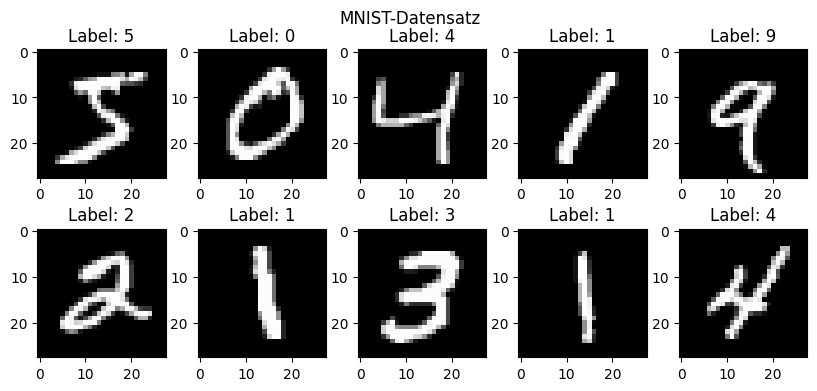

In [1]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Loading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Displaying information about the dataset
print("Anzahl der Trainingsdaten:", len(train_dataset))
print("Datentyp:", type(train_dataset[0][0]))
print("Größe des Bildes:", train_dataset[0][0].size)

# Anzeigen von einigen Beispielen
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.set_title(f'Label: {label}')

fig.suptitle("MNIST-Datensatz")
plt.subplots_adjust(hspace=0.4)

plt.show()

### Aufgabe 2.
Erstellen Sie eine Klasse für ein lineares Layer mit beliebig vielen Knoten. Implementieren Sie die
Methoden forward, backward und update mithilfe von numpy. Schreiben sie geeignete Unittests,
um die Funktionsweise der Funktion zu prüfen.

In [2]:
# Copilot and GPT-4 did this. 
# I had to change it a bit tho.
class LinearLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.weights_error = None
        self.bias_error = None
        self.input = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, output_error):
        input_error = np.dot(output_error, self.weights.T)
        self.weights_error = np.dot(self.input.T, output_error)
        self.bias_error = np.sum(output_error, axis=0, keepdims=True)
        return input_error

    def update(self, learning_rate):
        self.weights -= learning_rate * self.weights_error
        self.bias -= learning_rate * self.bias_error


In [3]:
# chatgpt
layer = LinearLayer(3, 2)
x = np.array([[1, 2, 3], [4, 5, 6]])
output = layer.forward(x)
assert output.shape == (2, 2)

### Aufgabe 3.
Erstellen Sie ein neuronales Netzwerk in numpy mit einem Hidden Linear Layer und einem Output
Knoten. Trainieren Sie das Netzwerk darauf, die Ziffer 4 korrekt zu identifizieren (d.h. der Output
soll 1 für diese Ziffer und 0 für alle anderen Ziffern sein). Trainieren Sie das Netzwerk auf den
Trainingsdaten und evaluieren Sie es anhand von Testdaten. Verwenden Sie eine geeignete Loss-
Funktion sowie Accuracy-Funktion und geben Sie deren mathematische Definition an. Begründen
Sie Ihre Wahl mit einer Abwägung der Vor- und Nachteile. Diskutieren Sie kurz weitere Optionen
für Loss und Accuracy.

In [4]:
# helper functions
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred), axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_layer = LinearLayer(input_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)

    def forward(self, x):
        hidden_layer_output = self.hidden_layer.forward(x)
        hidden_layer_activation = relu(hidden_layer_output)
        output_layer_output = self.output_layer.forward(hidden_layer_activation)
        output_layer_activation = softmax(output_layer_output)
        return output_layer_activation, hidden_layer_activation

    def backward(self, x, y_true, y_pred, learning_rate):
        output_error = y_pred - y_true
        hidden_error = self.output_layer.backward(output_error)
        # todo this is not working for obvious reasons, but I am not sure if it should be working and if so how
        # self.hidden_layer.backward(hidden_error)
        self.output_layer.update(learning_rate)
        # todo also this is not working
        # self.hidden_layer.update(learning_rate)


    def train(self, X, y, learning_rate=0.1, epochs=10):
        for epoch in range(epochs):
            for i in range(len(X)):
                y_prediction, hidden_layer_activation = self.forward(X[i])
                y_prediction_guess = np.zeros((1, 10))
                y_prediction_guess[0][y[i]] = 1
                self.backward(X[i], y_prediction_guess, y_prediction, learning_rate)
            print(f'Epoch: {epoch + 1}, Loss: {np.mean(cross_entropy(y_prediction_guess, y_prediction))}')


In [6]:
# Vorbereitung der Daten 
# reworked below
# X_train = train_dataset.data.reshape(-1, 28*28).numpy()
# y_train = (train_dataset.targets == 4).numpy().reshape(-1, 1)
# X_test = test_dataset.data.reshape(-1, 28*28).numpy()
# y_test = (test_dataset.targets == 4).numpy().reshape(-1, 1)

# real code
# reshape the data so that it is 784x1 instead of 28x28
# normalize data (division with 255)
X_train = train_dataset.data.numpy().reshape(-1, 784) / 255
# reshape the targets to be a column vector
y_train = train_dataset.targets.numpy().reshape(-1, 1)


# reshape the data so that it is 784x1 instead of 28x28
X_test = test_dataset.data.numpy().reshape(-1, 784) / 255
# reshape the targets to be a column vector
y_test = test_dataset.targets.numpy().reshape(-1, 1)



# input size is a 28x28 image, so 784 or 1 for each pixel
# output size is 10, one for each digit 0-9 todo should be 2 for this excercise
# hidden size is variable, change this to see how it affects the model
model = NeuralNetwork(784, 64, 10)

# train the model
model.train(X_train, y_train, learning_rate=0.1, epochs=5)

Epoch: 1, Loss: 1.3404420213322024
Epoch: 2, Loss: 1.2919835616789375
Epoch: 3, Loss: 1.2698148561062645
Epoch: 4, Loss: 1.2632279070416814
Epoch: 5, Loss: 1.2659332447517986


In [7]:
# test the model
correct = 0
total = 0

for i in range(len(X_test)):
    y_pred, _ = model.forward(X_test[i])
    y_pred = np.argmax(y_pred)
    y_true = y_test[i]
    if y_pred == y_true:
        correct += 1
    total += 1

print(f'Accuracy: {correct / total}')

Accuracy: 0.7976


### Aufgabe 4.
Trainieren Sie das Netzwerk mit verschiedenen Lernraten und Größen des Hidden Layers. Verfolgen
Sie während des Trainings die Entwicklung der Loss- und Accuracy-Funktionen auf Trainingsund
Testdatensätzen und entscheiden Sie, welche Wahl von Lernrate und Hidden Layer-Größe die
besten Ergebnisse in geringster Zeit liefert.

### Aufgabe 5.
Erweitern Sie das Netzwerk auf 3 Hidden Layer mit gleicher Größe und 10 Outputs. Das Ziel
ist die korrekte Klassifizierung aller Ziffern. Verwenden Sie eine geeignete Loss-Funktion sowie
Accuracy-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl
und diskutieren Sie kurz weitere Möglichkeiten. Variieren Sie die Lernrate und die Größe der
Hidden Layer und wählen Sie das beste Ergebnis aus.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=88bc6171-47da-4cbc-96f1-ee851c7ac9ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>